Part 0 – Imports and global setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set(style="whitegrid", context="talk")


Part 1 – Define the true sinc function and generate dense grid for evaluation

In [2]:
def sinc(x):
    x = np.asarray(x, dtype=np.float64)
    y = np.ones_like(x)
    mask = x != 0
    y[mask] = np.sin(x[mask]) / x[mask]
    return y

x_grid = np.linspace(-15, 15, 2000)
y_grid_true = sinc(x_grid)


Part 2 – Generate datasets with N = 100, 300, 1000 and add Gaussian noise

In [3]:
rng = np.random.default_rng(42)
Ns = [100, 300, 1000]
noise_std = 0.05

datasets = {}

for N in Ns:
    x = np.linspace(-15, 15, N)
    y_clean = sinc(x)
    noise = rng.normal(0.0, noise_std, size=N)
    y_noisy = y_clean + noise
    datasets[N] = {
        "x": x,
        "y_clean": y_clean,
        "y_noisy": y_noisy
    }


Part 3 – Visualize the true function and the three noisy datasets in a 3-plot row

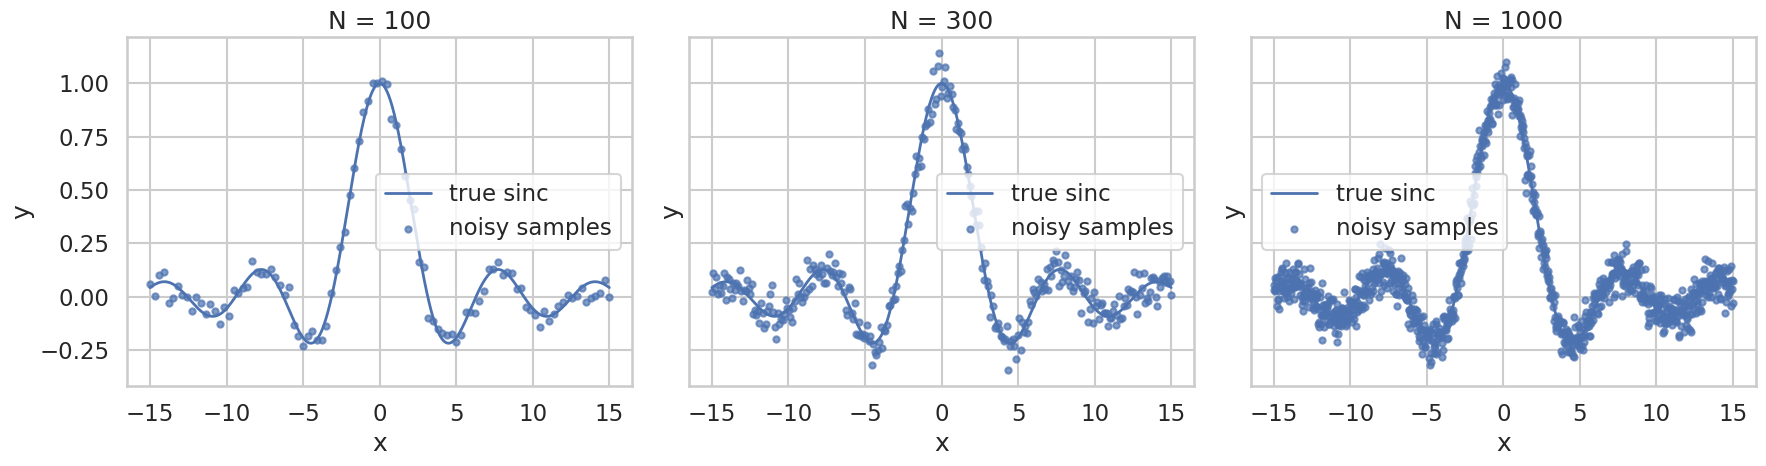

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, N in zip(axes, Ns):
    data = datasets[N]
    ax.plot(x_grid, y_grid_true, label="true sinc", linewidth=2)
    ax.scatter(data["x"], data["y_noisy"], s=20, alpha=0.7, label="noisy samples")
    ax.set_title(f"N = {N}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

plt.tight_layout()
plt.show()


Part 4 – Helper to build regression models (linear, polynomial, Ridge, Lasso, ElasticNet)

In [5]:
def make_linear():
    return LinearRegression()

def make_poly(degree):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression()
    )

def make_ridge(degree, alpha):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        Ridge(alpha=alpha)
    )

def make_lasso(degree, alpha):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        Lasso(alpha=alpha, max_iter=10000)
    )

def make_elasticnet(degree, alpha, l1_ratio):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    )


Part 5 – Generic evaluation function (fit model, predict on dense grid, compute MAE/MSE)

In [6]:
def fit_and_evaluate(model, x_train, y_train, x_eval, y_true_eval):
    X_train = x_train.reshape(-1, 1)
    X_eval = x_eval.reshape(-1, 1)

    model.fit(X_train, y_train)
    y_pred_eval = model.predict(X_eval)

    mse = mean_squared_error(y_true_eval, y_pred_eval)
    mae = mean_absolute_error(y_true_eval, y_pred_eval)

    return model, y_pred_eval, mse, mae


Part 6 – Define model configurations and evaluate them for each N and noise setting

In [7]:
degrees_poly = [2, 5, 9, 15]
ridge_alphas = [1e-3, 1e-1, 1.0, 10.0]
lasso_alphas = [1e-3, 1e-2, 1e-1]
elastic_alphas = [1e-3, 1e-2, 1e-1]
elastic_l1_ratios = [0.2, 0.5, 0.8]

results_rows = []
predictions_store = {}

for N in Ns:
    data = datasets[N]
    x = data["x"]
    for noise_type in ["clean", "noisy"]:
        y = data["y_clean"] if noise_type == "clean" else data["y_noisy"]

        key_base = (N, noise_type)
        predictions_store[key_base] = {}

        model_name = "linear"
        model = make_linear()
        fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y, x_grid, y_grid_true)
        results_rows.append({
            "N": N,
            "noise": noise_type,
            "method": model_name,
            "hyperparams": "",
            "MSE": mse,
            "MAE": mae
        })
        predictions_store[key_base][(model_name, "")] = y_pred

        for d in degrees_poly:
            model_name = "poly"
            hp = f"deg={d}"
            model = make_poly(d)
            fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y, x_grid, y_grid_true)
            results_rows.append({
                "N": N,
                "noise": noise_type,
                "method": model_name,
                "hyperparams": hp,
                "MSE": mse,
                "MAE": mae
            })
            predictions_store[key_base][(model_name, hp)] = y_pred

        for d in degrees_poly:
            for alpha in ridge_alphas:
                model_name = "ridge"
                hp = f"deg={d},alpha={alpha}"
                model = make_ridge(d, alpha)
                fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y, x_grid, y_grid_true)
                results_rows.append({
                    "N": N,
                    "noise": noise_type,
                    "method": model_name,
                    "hyperparams": hp,
                    "MSE": mse,
                    "MAE": mae
                })
                predictions_store[key_base][(model_name, hp)] = y_pred

        for d in degrees_poly:
            for alpha in lasso_alphas:
                model_name = "lasso"
                hp = f"deg={d},alpha={alpha}"
                model = make_lasso(d, alpha)
                fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y, x_grid, y_grid_true)
                results_rows.append({
                    "N": N,
                    "noise": noise_type,
                    "method": model_name,
                    "hyperparams": hp,
                    "MSE": mse,
                    "MAE": mae
                })
                predictions_store[key_base][(model_name, hp)] = y_pred

        for d in degrees_poly:
            for alpha in elastic_alphas:
                for l1r in elastic_l1_ratios:
                    model_name = "elasticnet"
                    hp = f"deg={d},alpha={alpha},l1={l1r}"
                    model = make_elasticnet(d, alpha, l1r)
                    fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y, x_grid, y_grid_true)
                    results_rows.append({
                        "N": N,
                        "noise": noise_type,
                        "method": model_name,
                        "hyperparams": hp,
                        "MSE": mse,
                        "MAE": mae
                    })
                    predictions_store[key_base][(model_name, hp)] = y_pred

results_df = pd.DataFrame(results_rows)
results_df.head()


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.59546e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.60564e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.69821e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.06239e-20): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.56665e-35): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/pytho

,N,noise,method,hyperparams,MSE,MAE
0,100,clean,linear,,0.090890,0.205719
1,100,clean,poly,deg=2,0.079122,0.204409
2,100,clean,poly,deg=5,0.061791,0.180259
3,100,clean,poly,deg=9,0.037850,0.166996
4,100,clean,poly,deg=15,0.074711,0.189009


Part 7 – Summarize best hyperparameters per method (by MSE) for each N and noise level

In [8]:
best_by_method = (
    results_df
    .sort_values("MSE")
    .groupby(["N", "noise", "method"], as_index=False)
    .first()
)

best_by_method


,N,noise,method,hyperparams,MSE,MAE
0,100,clean,elasticnet,"deg=15,alpha=0.001,l1=0.2",0.035574,0.145243
1,100,clean,lasso,"deg=15,alpha=0.001",0.035588,0.145251
2,100,clean,linear,,0.090890,0.205719
3,100,clean,poly,deg=9,0.037850,0.166996
4,100,clean,ridge,"deg=15,alpha=0.001",0.000293,0.015327
5,100,noisy,elasticnet,"deg=15,alpha=0.001,l1=0.2",0.035862,0.148595
6,100,noisy,lasso,"deg=15,alpha=0.001",0.035874,0.148604
7,100,noisy,linear,,0.090936,0.204611
8,100,noisy,poly,deg=9,0.038064,0.168559
9,100,noisy,ridge,"deg=15,alpha=1.0",0.000506,0.017445


Part 8 – Visualize MSE and MAE of best models for each N in a 3-plot row

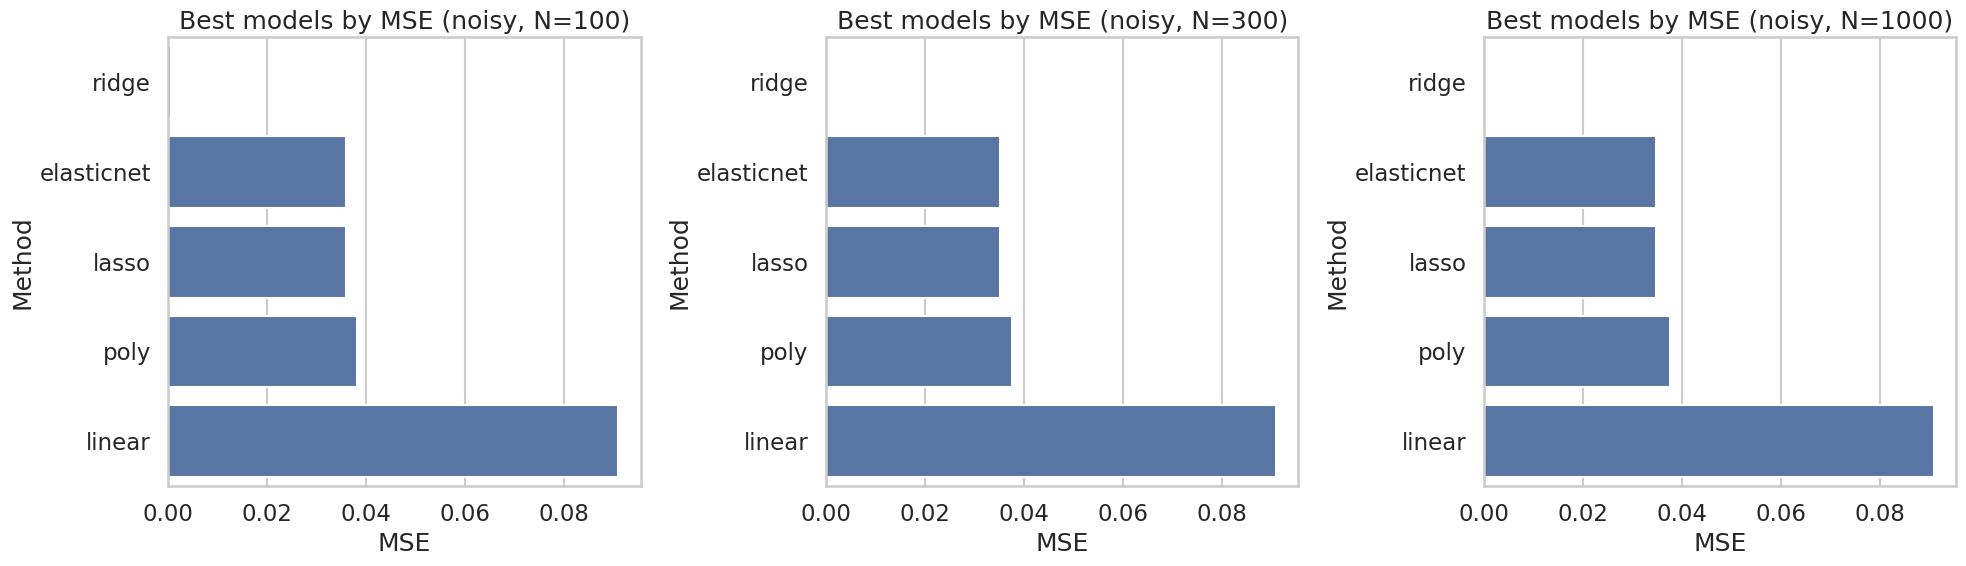

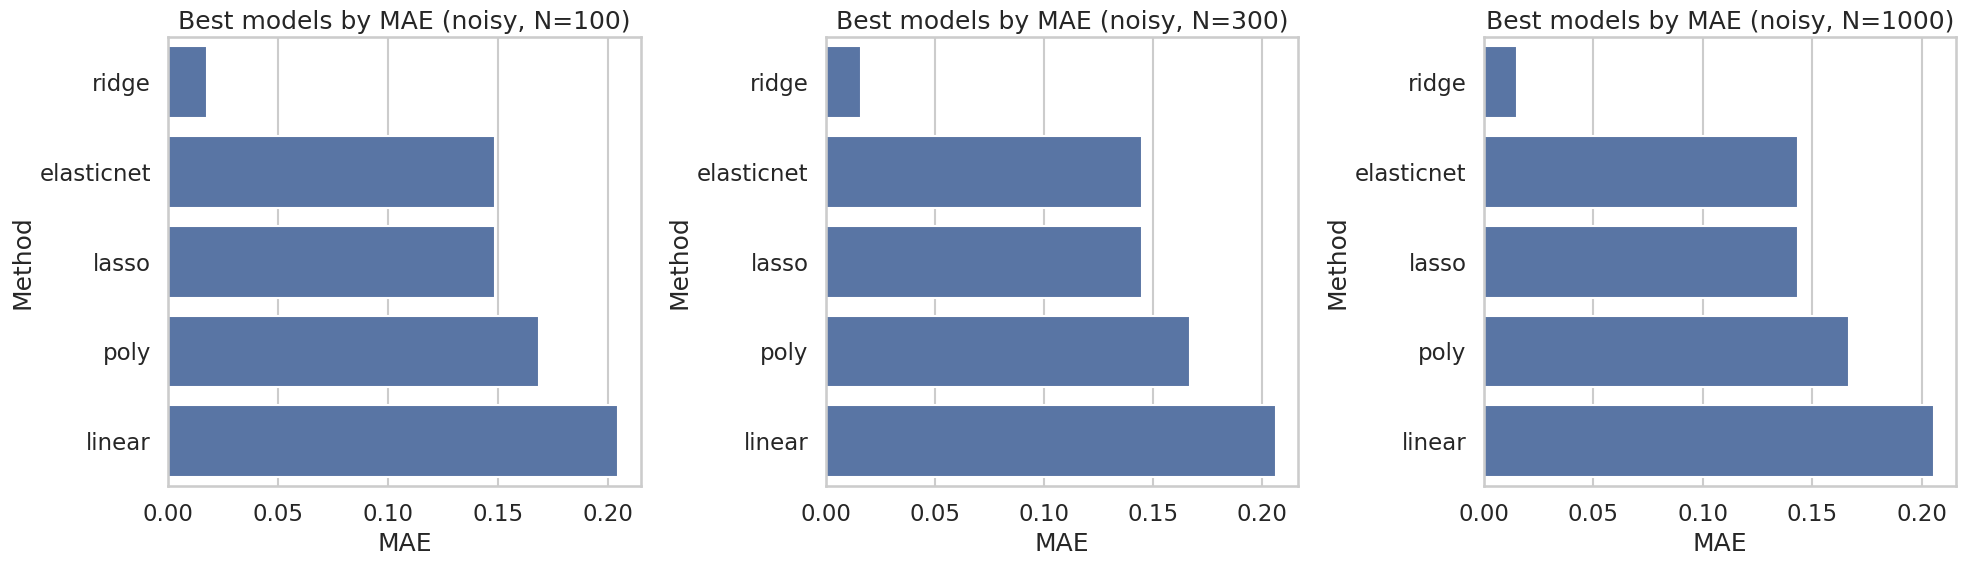

In [9]:
best_noise = best_by_method[best_by_method["noise"] == "noisy"]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

for ax, N in zip(axes, Ns):
    dfN = best_noise[best_noise["N"] == N].copy()
    dfN = dfN.sort_values("MSE")
    sns.barplot(data=dfN, x="MSE", y="method", orient="h", ax=ax)
    ax.set_title(f"Best models by MSE (noisy, N={N})")
    ax.set_xlabel("MSE")
    ax.set_ylabel("Method")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

for ax, N in zip(axes, Ns):
    dfN = best_noise[best_noise["N"] == N].copy()
    dfN = dfN.sort_values("MAE")
    sns.barplot(data=dfN, x="MAE", y="method", orient="h", ax=ax)
    ax.set_title(f"Best models by MAE (noisy, N={N})")
    ax.set_xlabel("MAE")
    ax.set_ylabel("Method")

plt.tight_layout()
plt.show()


Part 9 – Plot prediction curves of selected models for a given N (e.g., N = 300, noisy)

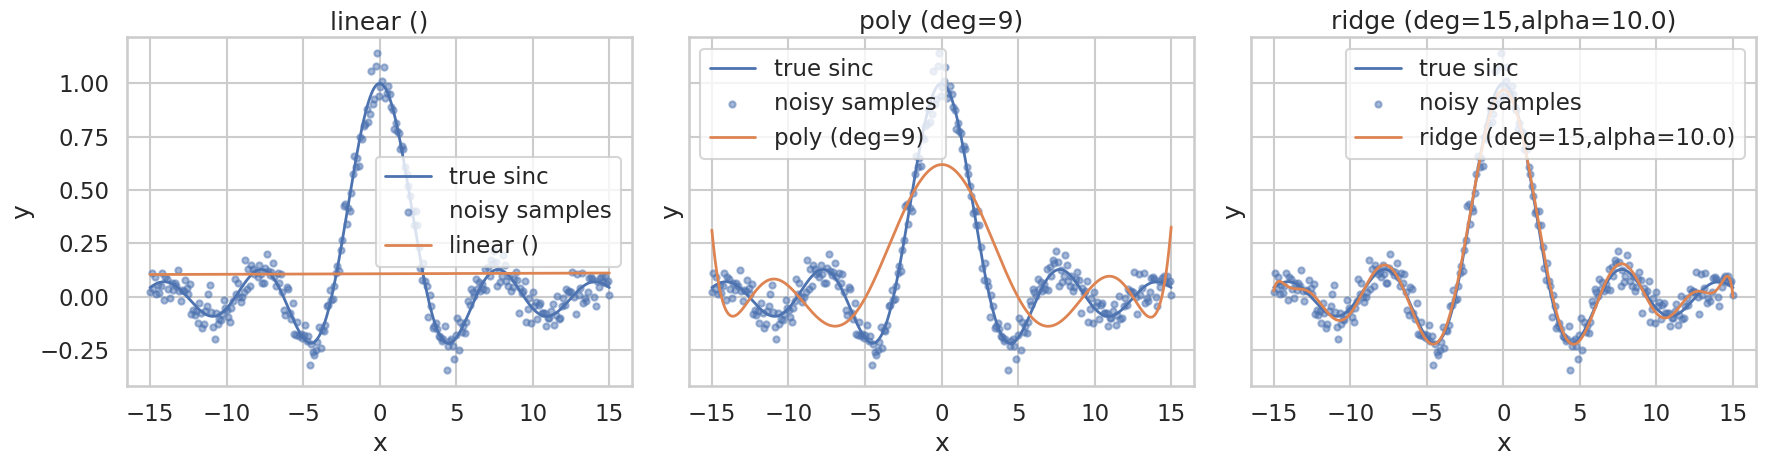

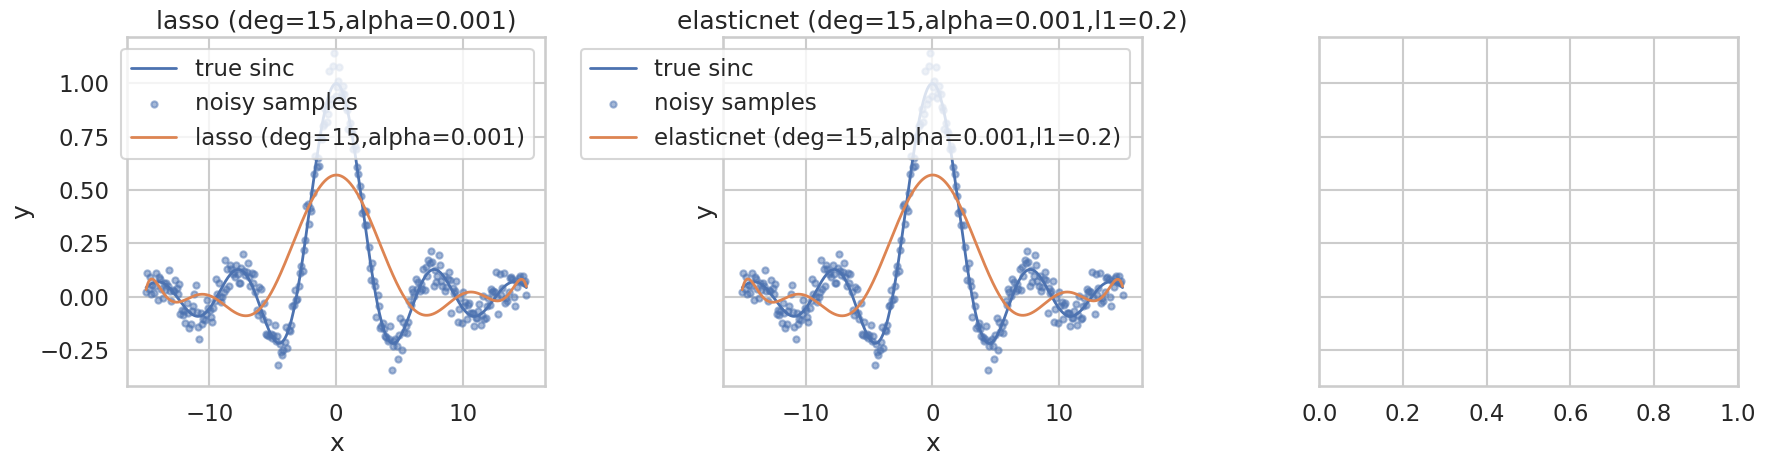

In [10]:
N_show = 300
noise_type = "noisy"
key_base = (N_show, noise_type)
data = datasets[N_show]
x = data["x"]
y = data["y_noisy"]

candidates = best_by_method[
    (best_by_method["N"] == N_show) &
    (best_by_method["noise"] == noise_type)
].copy()

models_to_plot = []

for m in ["linear", "poly", "ridge", "lasso", "elasticnet"]:
    row = candidates[candidates["method"] == m].sort_values("MSE").iloc[0]
    models_to_plot.append((row["method"], row["hyperparams"]))

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (method, hp) in zip(axes, models_to_plot[:3]):
    y_pred = predictions_store[key_base][(method, hp)]
    ax.plot(x_grid, y_grid_true, label="true sinc", linewidth=2)
    ax.scatter(x, y, s=20, alpha=0.5, label="noisy samples")
    ax.plot(x_grid, y_pred, label=f"{method} ({hp})", linewidth=2)
    ax.set_title(f"{method} ({hp})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (method, hp) in zip(axes, models_to_plot[3:], strict=False):
    y_pred = predictions_store[key_base][(method, hp)]
    ax.plot(x_grid, y_grid_true, label="true sinc", linewidth=2)
    ax.scatter(x, y, s=20, alpha=0.5, label="noisy samples")
    ax.plot(x_grid, y_pred, label=f"{method} ({hp})", linewidth=2)
    ax.set_title(f"{method} ({hp})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

plt.tight_layout()
plt.show()


Part 10 – Add outliers (e.g., 30% of points heavily perturbed) and repeat evaluation for N = 300

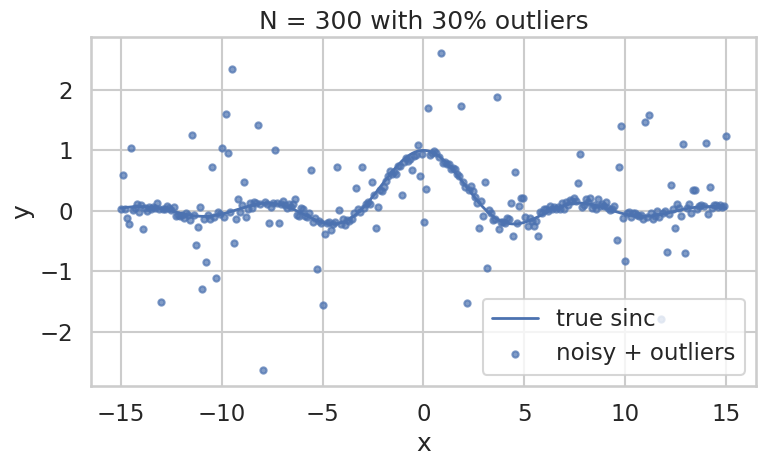

In [11]:
N_out = 300
data_out = datasets[N_out]
x_out = data_out["x"]
y_noisy_out = data_out["y_noisy"].copy()

rng = np.random.default_rng(123)
n_outliers = int(0.3 * N_out)
indices_outliers = rng.choice(N_out, size=n_outliers, replace=False)
y_noisy_out[indices_outliers] += rng.normal(0.0, 1.0, size=n_outliers)

datasets[N_out]["y_outlier"] = y_noisy_out

plt.figure(figsize=(8, 5))
plt.plot(x_grid, y_grid_true, label="true sinc", linewidth=2)
plt.scatter(x_out, y_noisy_out, s=20, alpha=0.7, label="noisy + outliers")
plt.title("N = 300 with 30% outliers")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()


Part 11 – Evaluate all models on the outlier dataset and compare best MSE/MAE

In [12]:
x = x_out
y = datasets[N_out]["y_outlier"]

results_out = []
pred_out_store = {}

for noise_label, y_vec in [("noisy_no_outliers", datasets[N_out]["y_noisy"]),
                           ("noisy_with_outliers", y)]:
    key_base = (noise_label,)
    pred_out_store[key_base] = {}

    model = make_linear()
    fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y_vec, x_grid, y_grid_true)
    results_out.append({
        "noise": noise_label,
        "method": "linear",
        "hyperparams": "",
        "MSE": mse,
        "MAE": mae
    })
    pred_out_store[key_base][("linear", "")] = y_pred

    for d in degrees_poly:
        hp = f"deg={d}"
        model = make_poly(d)
        fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y_vec, x_grid, y_grid_true)
        results_out.append({
            "noise": noise_label,
            "method": "poly",
            "hyperparams": hp,
            "MSE": mse,
            "MAE": mae
        })
        pred_out_store[key_base][("poly", hp)] = y_pred

    for d in degrees_poly:
        for alpha in ridge_alphas:
            hp = f"deg={d},alpha={alpha}"
            model = make_ridge(d, alpha)
            fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y_vec, x_grid, y_grid_true)
            results_out.append({
                "noise": noise_label,
                "method": "ridge",
                "hyperparams": hp,
                "MSE": mse,
                "MAE": mae
            })
            pred_out_store[key_base][("ridge", hp)] = y_pred

    for d in degrees_poly:
        for alpha in lasso_alphas:
            hp = f"deg={d},alpha={alpha}"
            model = make_lasso(d, alpha)
            fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y_vec, x_grid, y_grid_true)
            results_out.append({
                "noise": noise_label,
                "method": "lasso",
                "hyperparams": hp,
                "MSE": mse,
                "MAE": mae
            })
            pred_out_store[key_base][("lasso", hp)] = y_pred

    for d in degrees_poly:
        for alpha in elastic_alphas:
            for l1r in elastic_l1_ratios:
                hp = f"deg={d},alpha={alpha},l1={l1r}"
                model = make_elasticnet(d, alpha, l1r)
                fitted, y_pred, mse, mae = fit_and_evaluate(model, x, y_vec, x_grid, y_grid_true)
                results_out.append({
                    "noise": noise_label,
                    "method": "elasticnet",
                    "hyperparams": hp,
                    "MSE": mse,
                    "MAE": mae
                })
                pred_out_store[key_base][("elasticnet", hp)] = y_pred

results_out_df = pd.DataFrame(results_out)
best_out = (
    results_out_df
    .sort_values("MSE")
    .groupby(["noise", "method"], as_index=False)
    .first()
)

best_out


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.06739e-20): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.06777e-20): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.07123e-20): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.10586e-20): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.08978e-35): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/pytho

,noise,method,hyperparams,MSE,MAE
0,noisy_no_outliers,elasticnet,"deg=15,alpha=0.001,l1=0.2",0.035203,0.145021
1,noisy_no_outliers,lasso,"deg=15,alpha=0.001",0.035217,0.145027
2,noisy_no_outliers,linear,,0.090894,0.206168
3,noisy_no_outliers,poly,deg=9,0.037632,0.167046
4,noisy_no_outliers,ridge,"deg=15,alpha=10.0",0.000358,0.016138
5,noisy_with_outliers,elasticnet,"deg=15,alpha=0.01,l1=0.8",0.040046,0.161242
6,noisy_with_outliers,lasso,"deg=15,alpha=0.01",0.040032,0.161214
7,noisy_with_outliers,linear,,0.093218,0.227842
8,noisy_with_outliers,poly,deg=9,0.043125,0.176819
9,noisy_with_outliers,ridge,"deg=15,alpha=0.001",0.009457,0.080082


Part 12 – Visualize robustness to outliers: best models before vs after outliers

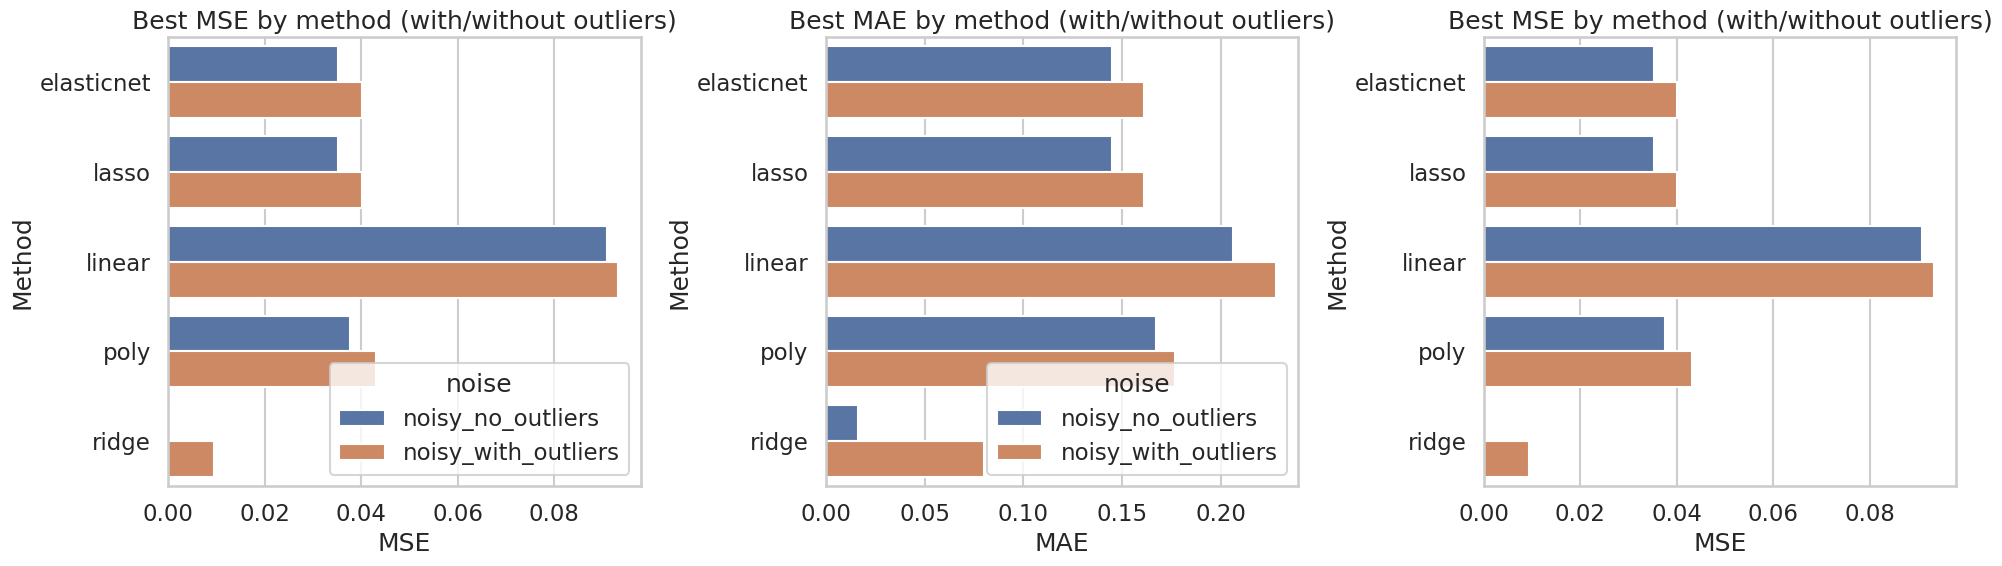

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

for ax, metric in zip(axes, ["MSE", "MAE"] + ["MSE"]):
    if metric == "MSE":
        df_plot = best_out.copy()
    else:
        df_plot = (
            results_out_df
            .sort_values(metric)
            .groupby(["noise", "method"], as_index=False)
            .first()
        )

    sns.barplot(
        data=df_plot,
        x=metric if metric != "MSE" or ax is axes[0] else "MSE",
        y="method",
        hue="noise",
        orient="h",
        ax=ax
    )
    ax.set_title(f"Best {metric} by method (with/without outliers)")
    ax.set_xlabel(metric)
    ax.set_ylabel("Method")

axes[2].legend_.remove()
plt.tight_layout()
plt.show()


In this experiment, the goal was to evaluate the accuracy and robustness of various regression and regularization techniques for approximating the sinc(x) function under increasing data sizes, added Gaussian noise, and significant outliers. The function was sampled at 100, 300, and 1000 evenly spaced points over [-15, 15], and both clean and noisy versions were used to train multiple models, including simple linear regression, polynomial regression of various degrees, and regularized methods such as Ridge (L2), Lasso (L1), and ElasticNet (L1+L2). Each model was evaluated on a dense grid using MSE and MAE, and results were visualized through comparative barplots and prediction curves. The findings show clear trends: low-degree polynomials underfit, high-degree polynomials tend to overfit noisy data, and regularization—especially Ridge and ElasticNet—provides the most stable and accurate approximations across different sample sizes. When 30% outliers were introduced, unregularized polynomial models broke down, while Ridge and ElasticNet remained significantly more resilient, demonstrating strong resistance to noise and outliers and offering the best overall performance.